Problem statement:

![imgae](https://upload.wikimedia.org/wikipedia/commons/thumb/4/43/HMMGraph.svg/1024px-HMMGraph.svg.png)

In [1]:
import jax.numpy as jnp
import numpyro.distributions as dist
import numpyro
from numpyro.infer import MCMC, NUTS
import numpy as np
from jax import random
import arviz
import tqdm
from collections import Counter
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

rng_key = random.PRNGKey(10)
rng_key

/Users/douglas.wu/code/miniconda3/envs/jax/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DeviceArray([ 0, 10], dtype=uint32)

In [2]:
weather = {0: "rainy", 1: "sunny"}
activity = {0: "walk", 1: "shop", 2: "clean"}

transition_prob = jnp.array([
    [0.7, 0.3], 
    [0.4, 0.6]
])

emission_prob = jnp.array([
    [0.1, 0.4, 0.5],
    [0.6, 0.3, 0.1]
])
start_prob = jnp.array([0.6,0.4])
start_prob, transition_prob, emission_prob
#dist.Categorical(start_prob).sample()

(DeviceArray([0.6, 0.4], dtype=float32),
 DeviceArray([[0.7, 0.3],
              [0.4, 0.6]], dtype=float32),
 DeviceArray([[0.1, 0.4, 0.5],
              [0.6, 0.3, 0.1]], dtype=float32))

In [3]:
# simulate data
num_data=200
weathers, activities = [], []
_weather = dist.Categorical(start_prob).sample(rng_key)
subkeys = random.split(key=rng_key, num=num_data)
for i, subkey in enumerate(subkeys):
    _weather = dist.Categorical(transition_prob[_weather]).sample(subkey)
    subsub_key = random.split(key=subkey, num=1)[0]
    _activity = dist.Categorical(emission_prob[_weather]).sample(subsub_key)
    weathers.append(int(_weather))
    activities.append(int(_activity))
activities=jnp.array(activities)
weathers = jnp.array(weathers)
jnp.unique(activities[weathers==0], return_counts=True), jnp.unique(activities[weathers==1], return_counts=True), emission_prob[1], jnp.unique(weathers, return_counts=True)

((DeviceArray([0, 1, 2], dtype=int32), DeviceArray([11, 53, 47], dtype=int32)),
 (DeviceArray([0, 1, 2], dtype=int32), DeviceArray([42, 35, 12], dtype=int32)),
 DeviceArray([0.6, 0.3, 0.1], dtype=float32),
 (DeviceArray([0, 1], dtype=int32), DeviceArray([111,  89], dtype=int32)))

In [4]:
def model(activities, weathers):

    transition_prior = numpyro.sample("transition_prob", dist.Dirichlet( jnp.ones((2,2)) / 2 ))
    emission_prior = numpyro.sample("emission_prob", dist.Dirichlet( jnp.ones((2,3)) / 3  ))

    current_weather = weathers[0]
    weathers = weathers[1:]
    activities = activities[1:]
    
    with numpyro.plate("test", 1):
        for i, (activity, weather) in enumerate(zip(activities, weathers)):
            current_weather = numpyro.sample(f"weather_{i}", dist.Categorical(transition_prior[current_weather]), obs=weathers[i])
            _activity = numpyro.sample(f"act_{i}", dist.Categorical(emission_prior[current_weather]), obs=activities[i])

In [5]:
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=200)
mcmc.run(rng_key, activities, weathers)

sample: 100%|██████████| 700/700 [01:59<00:00,  5.86it/s, 7 steps of size 7.50e-01. acc. prob=0.88]  


In [6]:
mcmc.print_summary()  


                          mean       std    median      5.0%     95.0%     n_eff     r_hat
  emission_prob[0,0]      0.10      0.03      0.10      0.05      0.16    213.33      1.00
  emission_prob[0,1]      0.48      0.05      0.48      0.40      0.57    282.38      1.00
  emission_prob[0,2]      0.42      0.06      0.42      0.32      0.51    316.93      1.00
  emission_prob[1,0]      0.48      0.05      0.48      0.40      0.56    209.42      1.00
  emission_prob[1,1]      0.39      0.05      0.39      0.31      0.48    259.43      1.00
  emission_prob[1,2]      0.14      0.04      0.13      0.08      0.20    275.77      1.00
transition_prob[0,0]      0.71      0.04      0.70      0.65      0.77    153.25      1.00
transition_prob[0,1]      0.29      0.04      0.30      0.23      0.35    153.25      1.00
transition_prob[1,0]      0.36      0.05      0.35      0.29      0.45    230.73      1.00
transition_prob[1,1]      0.64      0.05      0.65      0.55      0.71    230.73      1.0

array([[<AxesSubplot: title={'center': 'emission_prob\n0, 0'}>,
        <AxesSubplot: title={'center': 'emission_prob\n0, 1'}>,
        <AxesSubplot: title={'center': 'emission_prob\n0, 2'}>],
       [<AxesSubplot: title={'center': 'emission_prob\n1, 0'}>,
        <AxesSubplot: title={'center': 'emission_prob\n1, 1'}>,
        <AxesSubplot: title={'center': 'emission_prob\n1, 2'}>],
       [<AxesSubplot: title={'center': 'transition_prob\n0, 0'}>,
        <AxesSubplot: title={'center': 'transition_prob\n0, 1'}>,
        <AxesSubplot: title={'center': 'transition_prob\n1, 0'}>],
       [<AxesSubplot: title={'center': 'transition_prob\n1, 1'}>,
        <AxesSubplot: >, <AxesSubplot: >]], dtype=object)

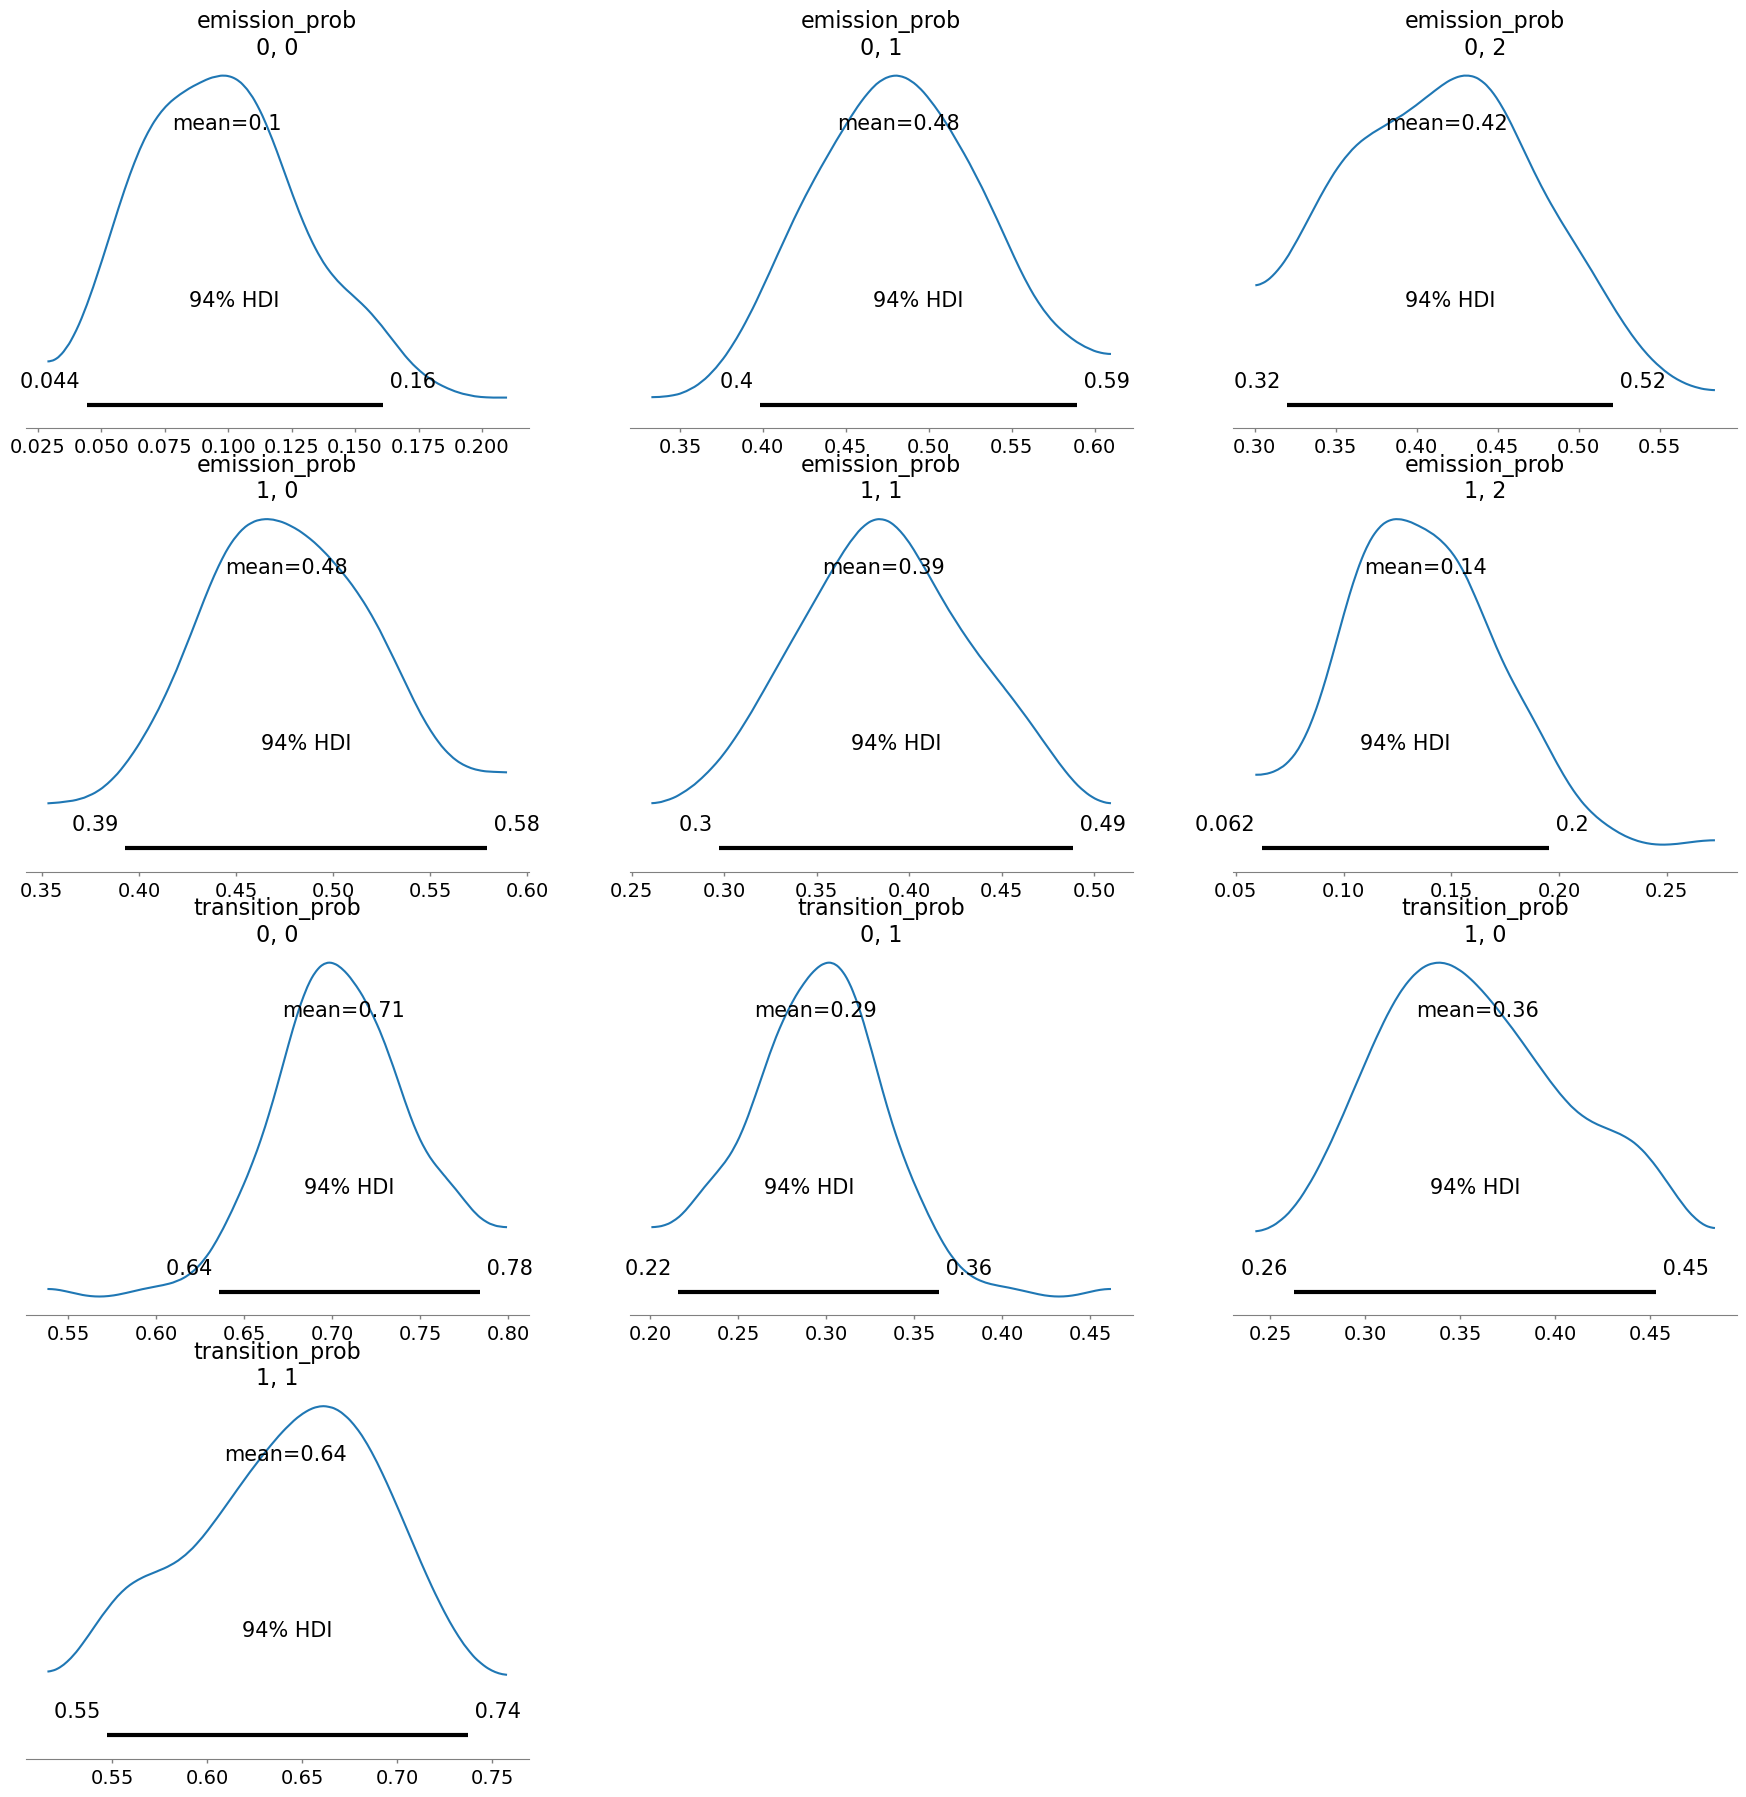

In [7]:
obj = arviz.from_numpyro(mcmc)
arviz.plot_posterior(obj)

# Testing #

In [8]:
# IQ data from https://github.com/ericmjl/bayesian-generalized-abcde-testing/blob/master/notebooks/01-from-ab-to-abcde.ipynb
drug = [  99.,  110.,  107.,  104.,  103.,  105.,  105.,  110.,   99.,
        109.,  100.,  102.,  104.,  104.,  100.,  104.,  101.,  104.,
        101.,  100.,  109.,  104.,  105.,  112.,   97.,  106.,  103.,
        101.,  101.,  104.,   96.,  102.,  101.,  100.,   92.,  108.,
         97.,  106.,   96.,   90.,  109.,  108.,  105.,  104.,  110.,
         92.,  100.]

placebo = [  95.,  105.,  103.,   99.,  104.,   98.,  103.,  104.,  102.,
         91.,   97.,  101.,  100.,  113.,   98.,  102.,  100.,  105.,
         97.,   94.,  104.,   92.,   98.,  105.,  106.,  101.,  106.,
        105.,  101.,  105.,  102.,   95.,   91.,   99.,   96.,  102.,
         94.,   93.,   99.,   99.,  113.,   96.]


drug_and_studying = [  98.,  105.,  104.,   110.,  108.,   98.,  103.,  104.,  102.,
         91.,   97.,  101.,  100.,  113.,   98.,  102.,  100.,  105.,
         97.,   109.,   92.,   98.,  105.,  106.,  101.,  106.,
        105.,  101.,  115.,  102.,   95.,   91.,   99.,   99.,  102.,
         94.,   99.,   99.,  113.,   100.]


studying = [  112.,  115.,  124.,   120.,  128.,   138.,  113.,  124.,  102.,
         101.,   127.,  111.,  100.,  121.,   118.,  112.,  100.,  105.,
         147.,   109.,   112.,   128.,  115.,  116.,  101.,  106.,
        105.,  111.,  115.,  112.,   95.,   121.,   129.,   139.,  102.,
         114.,   129.,   119.,  113.,   120.]


data = [drug, drug_and_studying, placebo, studying]

In [9]:
def model():
    mu = numpyro.sample("mu", dist.Normal(0, scale=1000), sample_shape=(4,))
    sd = numpyro.sample("sd", dist.HalfCauchy(scale=1000), sample_shape=(4,))
    
    sim_data = []
    for i in range(len(data)):
        numpyro.sample(
            f"iq_{i}", 
            dist.Normal(loc=mu[i], scale=sd[i]), 
            obs=jnp.array(data[i])
        )
    
    difference = numpyro.deterministic(
        "difference", 
        numpyro.sample("comp_3", dist.Normal(loc=mu[3], scale=sd[3])) -
        numpyro.sample("comp_2", dist.Normal(loc=mu[2], scale=sd[2])),
    )

    
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=200)
mcmc.run(rng_key)

sample: 100%|██████████| 700/700 [00:03<00:00, 221.95it/s, 7 steps of size 5.67e-01. acc. prob=0.92]


In [10]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
    comp_2    100.66      5.15    100.96     92.70    108.23    349.24      1.00
    comp_3    115.83     12.01    114.82     96.37    135.10    611.16      1.00
     mu[0]    102.72      0.70    102.71    101.72    104.00    416.72      1.00
     mu[1]    101.58      0.89    101.60    100.18    103.09    551.40      1.00
     mu[2]    100.36      0.82    100.39     98.86    101.56    449.65      1.00
     mu[3]    115.77      1.66    115.64    113.32    118.68    449.93      1.00
     sd[0]      5.04      0.51      4.96      4.35      5.87    628.14      1.00
     sd[1]      5.81      0.68      5.74      4.58      6.74    345.74      1.02
     sd[2]      5.30      0.57      5.25      4.40      6.13    488.84      1.00
     sd[3]     11.93      1.47     11.83      9.65     14.08    290.58      1.00

Number of divergences: 0


(array([1., 1., 0., 0., 0., 1., 0., 1., 0., 1.]),
 array([-15.86181641, -14.74063683, -13.6194582 , -12.49827862,
        -11.37709999, -10.25592041,  -9.13474083,  -8.0135622 ,
         -6.89238262,  -5.77120352,  -4.65002441]),
 <BarContainer object of 10 artists>)

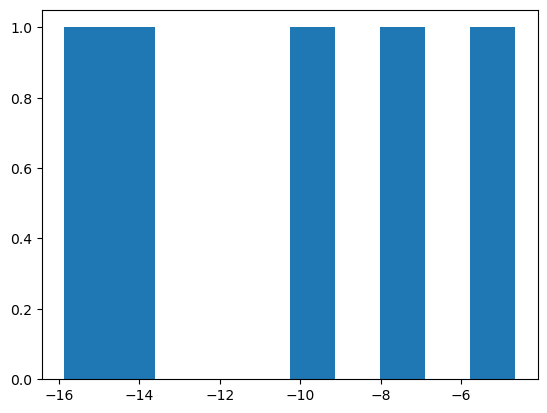

In [11]:
predictive = numpyro.infer.Predictive(model, num_samples=1000, return_sites=['difference'])
predictions = predictive(rng_key)
diff = predictions['difference']
diff = diff[ (diff > -20) & (diff < 20) ]
plt.hist(diff, bins=10)

array([[<AxesSubplot: title={'center': 'comp_2'}>,
        <AxesSubplot: title={'center': 'comp_3'}>,
        <AxesSubplot: title={'center': 'difference'}>],
       [<AxesSubplot: title={'center': 'mu\n0'}>,
        <AxesSubplot: title={'center': 'mu\n1'}>,
        <AxesSubplot: title={'center': 'mu\n2'}>],
       [<AxesSubplot: title={'center': 'mu\n3'}>,
        <AxesSubplot: title={'center': 'sd\n0'}>,
        <AxesSubplot: title={'center': 'sd\n1'}>],
       [<AxesSubplot: title={'center': 'sd\n2'}>,
        <AxesSubplot: title={'center': 'sd\n3'}>, <AxesSubplot: >]],
      dtype=object)

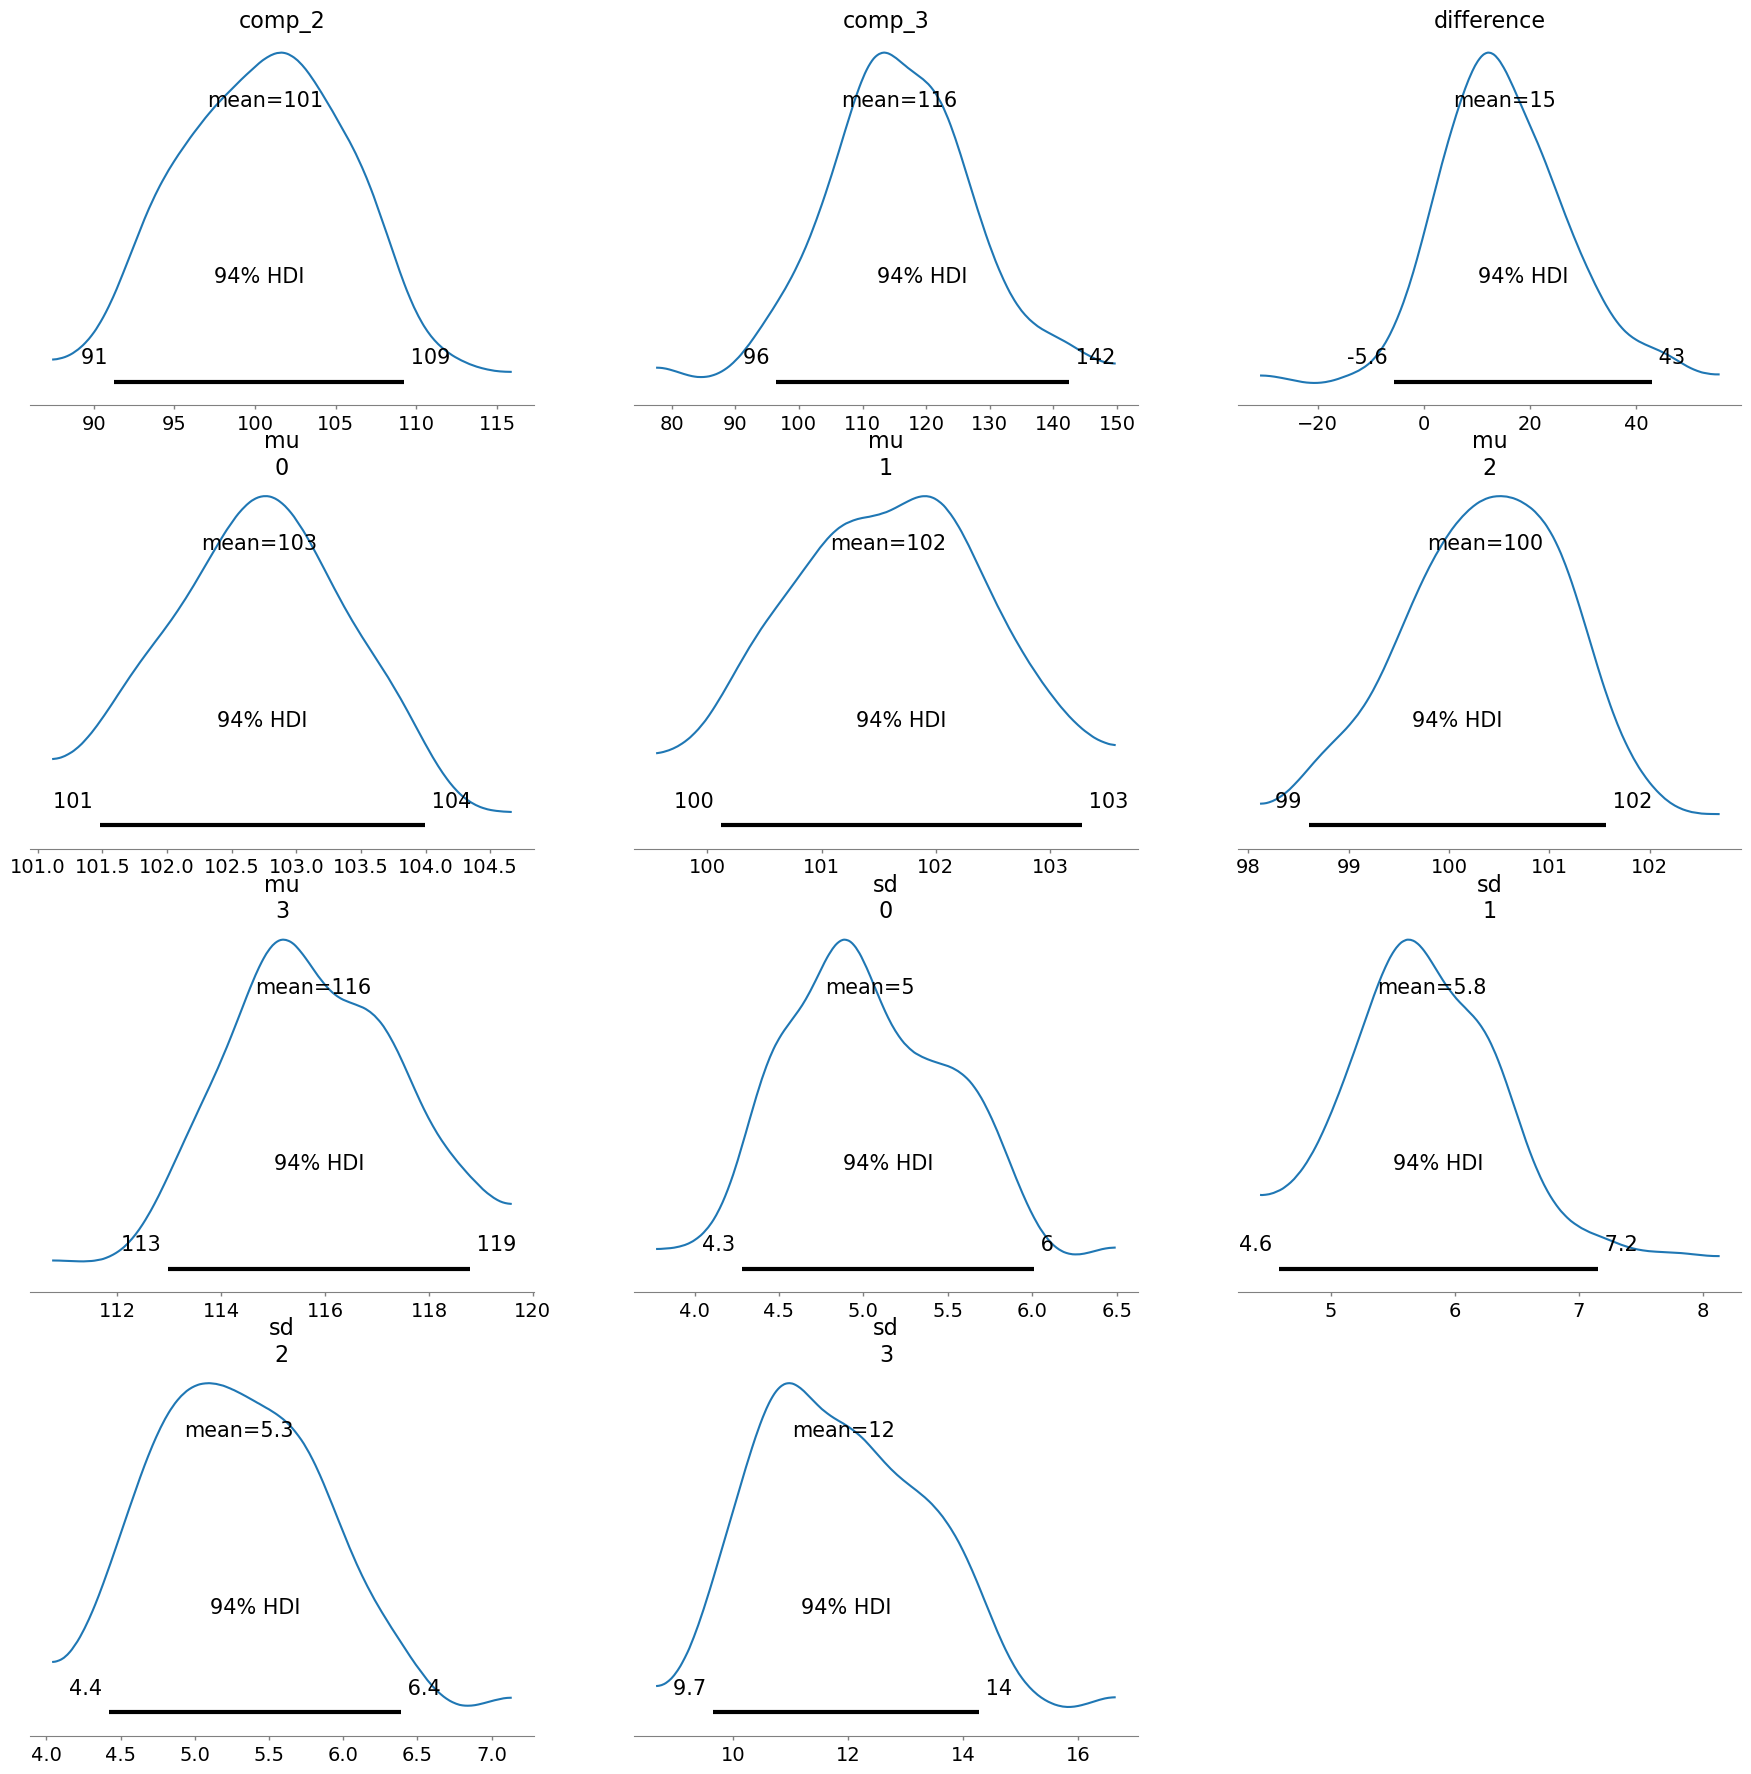

In [12]:
obj = arviz.from_numpyro(mcmc)
arviz.plot_posterior(obj)

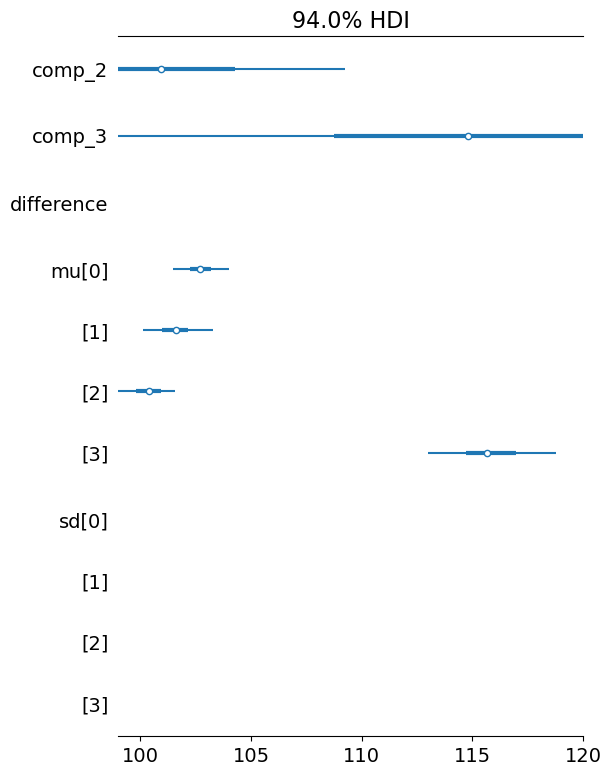

In [13]:
fig = arviz.plot_forest(obj, )
for ax in fig:
    ax.set_xlim(99,120)

<AxesSubplot: ylabel='Density'>

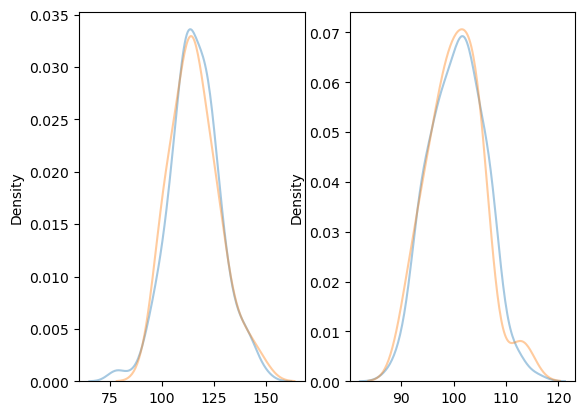

In [14]:
fig = plt.figure()
ax = fig.add_subplot(121)
sns.kdeplot(mcmc.get_samples()['comp_3'], alpha=0.4, ax=ax)
sns.kdeplot(data[3], alpha=0.4, ax=ax)


ax = fig.add_subplot(122)
sns.kdeplot(mcmc.get_samples()['comp_2'], alpha=0.4, ax=ax)
sns.kdeplot(data[2], alpha=0.4, ax=ax)